In [30]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 
from PIL import Image 
import time 
from IPython import display

%matplotlib inline 

In [31]:
import utils as utils

In [32]:
tf.test.is_gpu_available()

False

# Prepare Dataset 

In [33]:
BATCH_SIZE = 32 
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 8    # Shuffle the training data by a chunck of this many observations

In [34]:
filenames = utils.get_filenames_list('data/dataset128-easy-snp/')
train_ds = utils.create_dataset_128(filenames, SHUFFLE_BUFFER_SIZE, AUTOTUNE, BATCH_SIZE)

# Model building 

Regular autoencoder instead of VAE.  Hoping a higher bias model to capture more details about the image (ribs and such) 

## Architecture 

In [35]:
LATENT_DIM = 150

Model architecture from tf tutorials on MNIST dataset 

In [36]:
encoder = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(128, 128, 1)),
        tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(4, 4), activation='relu'),
        tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(3, 3), activation='relu'),
        tf.keras.layers.Conv2D(filters=90, kernel_size=3, strides=(2, 2), activation='relu'),
        tf.keras.layers.Flatten(),
        # No activation
        tf.keras.layers.Dense(LATENT_DIM) 
        ])


In [37]:
decoder = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(LATENT_DIM,)),
        tf.keras.layers.Dense(units=8*8*32, activation=tf.nn.relu),
        tf.keras.layers.Reshape(target_shape=(8, 8, 32)),
        tf.keras.layers.Conv2DTranspose(filters=90, kernel_size=3, strides=2, padding='same',
            activation='relu'),
        tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same',
            activation='relu'),
        tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=4, padding='same',
            activation='relu'),
        # No activation
        tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same'),
        ])


In [38]:
encoder.summary(), decoder.summary(), 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 90)          51930     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1440)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 150)               216150    
Total params: 286,896
Trainable params: 286,896
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
Layer (type)              

(None, None)

Utilities for autoencoder

In [39]:
@tf.function
def sample(epsilon=None):
    """ Forward pass through second half of network.  Used for generating data samples.    
        Sample epsilon using tensorflow utilities 
    """
    if epsilon is None:
        epsilon = tf.random.normal(shape=(100, LATENT_DIM))
    return decode(epsilon, apply_sigmoid=True)



def encode(X): 
    """ Forward pass of encoder network 
    
        Input is data vector, X.  
        Output is latent feature vector.  
    """
    return encoder(X)


def reparameterize(mean, logvar):
    """ Forward pass through bottleneck section of network.  Outputs z vector.  
    """
    epsilon = tf.random.normal(shape=mean.shape)
    return epsilon * tf.exp(logvar * .5) + mean




def decode(z, apply_sigmoid=False): 
    """ Forward pass of decoder network.  
    
        Input is a sampled z vector 
    """
    logits = decoder(z) 
    
    if apply_sigmoid: 
        probs = tf.sigmoid(logits)
        return probs 
    return logits 
    

# Optimizer and loss 

In [40]:
optimizer = tf.keras.optimizers.RMSprop(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    """ Utility for ELBO.
    """
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(x, y): 
    """ Calculates model loss 
    """
    # Forward pass through the network 
    latent = encode(x)
    x_logit = decode(latent)
    
    # Calculate reconstruction loss (binary cross entropy)
    # Reconstruction loss will evaluate the similarity between inp and out. 
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=y)
    return cross_ent

    
#     # Calculate regularization portion (ELBO) 
#     logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
#     logpz = log_normal_pdf(z, 0., 0.)
#     logqz_x = log_normal_pdf(z, mean, logvar)
#     return -tf.reduce_mean(logpx_z + logpz - logqz_x)
    

Training functions 

In [41]:
@tf.function
def train_step(x, y, optimizer):
    """Executes one training step and returns the loss.  

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    
    # Use GradientTape to record a computation graph 
    with tf.GradientTape() as tape:
        loss = compute_loss(x, y)
        
    # The tape is used to compute gradients using the computation graph 
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    optimizer.apply_gradients(zip(gradients, trainable_vars))
    
    return loss 


# Utilities for image generation


In [42]:
num_examples_to_generate = 30
batch_size=32 

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, LATENT_DIM])

In [43]:
def generate_and_save_images(epoch, test_sample):
    """ Utility for saving image during training epoch   
    """
    latent = encode(test_sample)
    # Use the sample function to generate a new sample z vector 
    predictions = sample(latent)
    fig = plt.figure(figsize=(25, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(2, 15, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig('temp_training_images/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


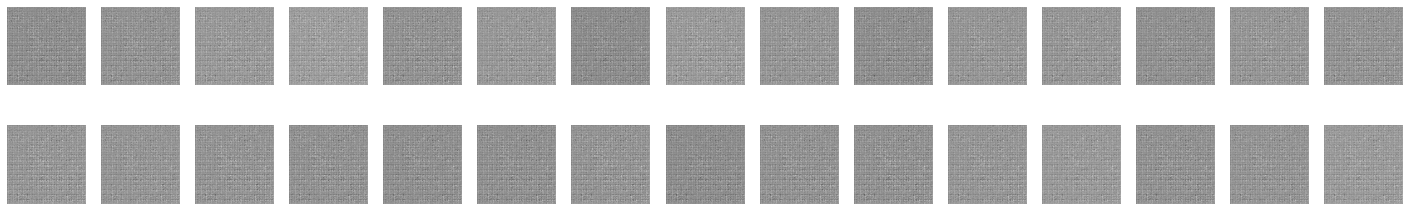

In [44]:
# Set aside a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate

for test_batch in train_ds.take(1):
    test_sample = test_batch[0][0:num_examples_to_generate, :, :, :]
generate_and_save_images(0, test_sample)

## Trainin' 

In [45]:
epochs = 100
num_examples_to_generate = 16

In [46]:
losses = []

Epoch: 100, time elapse for current epoch: 8.832513093948364


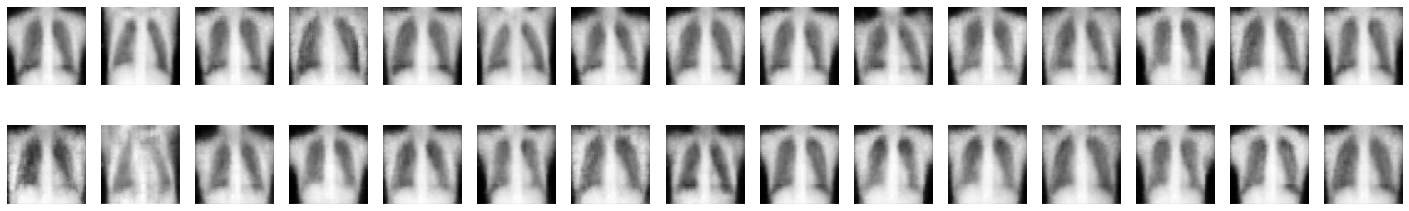

In [47]:
for epoch in range(1, epochs + 1):
    
    # tic
    start_time = time.time()
    
    for train_x, train_y in train_ds: 
        l = train_step(train_x, train_y, optimizer)
        losses.append(l)

    print("Epoch {}.  Loss: {}".format(epoch, l))
    
    # toc 
    end_time = time.time()

    display.clear_output(wait=False)
    print('Epoch: {}, time elapse for current epoch: {}'
        .format(epoch, end_time - start_time))
    generate_and_save_images(epoch, test_sample) 

## Save generated as GIF 

In [48]:
import imageio, glob

anim_file = 'generated_samples.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('temp_training_images/image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

# Testing 
Take and image, pass through network.

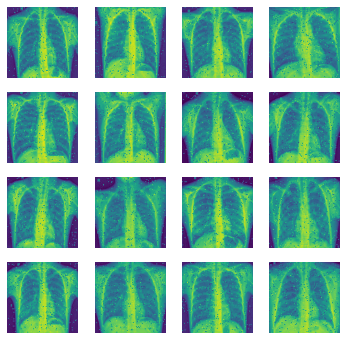

In [49]:
for i in train_ds.take(1): 
    ims = i[0]
    orgs = i[1]
    
fig, ax = plt.subplots(4, 4, figsize=(6, 6))
ax = ax.reshape(-1) 

for i, ax in enumerate(ax): 
    ax.imshow(np.squeeze(ims[i]))
    ax.axis(False)

## Pass through network 

In [50]:
latent = encode(ims)
x_logit = decode(latent)

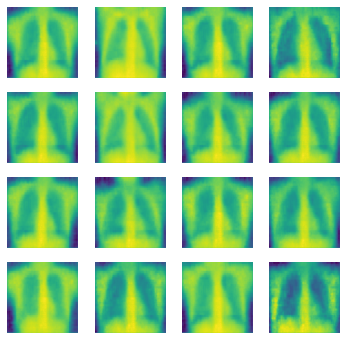

In [51]:
fig, ax = plt.subplots(4, 4, figsize=(6, 6))
ax = ax.reshape(-1)

for i, ax in enumerate(ax):
    ax.imshow(np.squeeze(x_logit[i]))
    ax.axis(False)

Text(0.5, 1.0, 'Original')

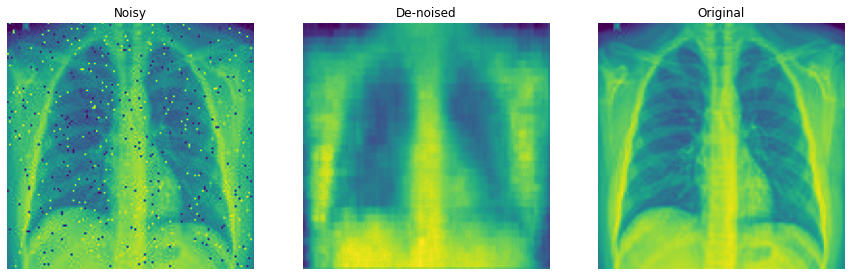

In [53]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
i = 15

axes[0].imshow(np.squeeze(ims[i]))
axes[0].axis(False)
axes[0].set_title('Noisy')

axes[1].imshow(np.squeeze(x_logit[i]))
axes[1].axis(False)
axes[1].set_title('De-noised')

axes[2].imshow(np.squeeze(orgs[i]))
axes[2].axis(False)
axes[2].set_title('Original')


## SAve model 


In [54]:
from datetime import datetime
import os

now = datetime.now().date()
os.makedirs('saved_model/' + str(now) + '/encoder2/')
os.makedirs('saved_model/' + str(now) + '/decoder2/')


In [55]:
encoder.save('saved_model/' + str(now) + '/encoder2')
decoder.save('saved_model/' + str(now) + '/decoder2')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/2020-11-25/encoder2\assets
INFO:tensorflow:Assets written to: saved_model/2020-11-25/decoder2\assets


In [56]:
losses_lst = [l.numpy() for l in losses]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "H:\Anaconda\envs\tf2\lib\site-packages\IPython\core\interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-56-241f15d26849>", line 1, in <module>
    losses_lst = [l.numpy() for l in losses]
  File "<ipython-input-56-241f15d26849>", line 1, in <listcomp>
    losses_lst = [l.numpy() for l in losses]
  File "H:\Anaconda\envs\tf2\lib\site-packages\tensorflow_core\python\framework\ops.py", line 943, in numpy
    return maybe_arr.copy() if isinstance(maybe_arr, np.ndarray) else maybe_arr
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "H:\Anaconda\envs\tf2\lib\site-packages\IPython\core\interactiveshell.py", line 2045, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another ex

TypeError: object of type 'NoneType' has no len()

In [33]:
with open('saved_model/' + str(now) + '/losses2.txt', 'w') as f:
    for item in losses_lst:
        f.write("%s\n" % item)